# Demo of Variational Interpretable Concept Embeddings (VICE)

## Install dependencies

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import argparse
import os
import random
import torch

import numpy as np
from typing import Tuple

import utils
import visualization
import optimization
from data import TripletData
from torch.utils.data import DataLoader

## I/O

In [22]:
# specify input and output directories
# triplets_dir = './data/files/amt/'
triplets_dir = './data/own/'

results_dir = './output_own/results/'
plots_dir = './output_own/plots/'

### Variables and hyperparameters

In [5]:
# define variables
task = 'odd-one-out' # whether to perform an odd-one-out (3AFC) or target-matching (2AFC) triplet task
epochs = 1500 # maximum number of epochs to run optimization process
burnin = 500 # minimum number of epochs to run optimization process
init_dim = 100 # initial embedding dimensionality of VICE
batch_size = 128 # use power of 2 if you intend to perfrom model training on a GPU, else see whatever works best for you
optim = 'adam' # we recommend to use Adam but you can try SGD with momentum
mixture = 'gaussian' # spike-and-slab Gaussian mixture prior (if set to "laplace", a mixture of two Laplace distributions will be used as the prior)
mc_samples = 10 # number of weight samples used in Monte Carlo (MC) sampling
eta = 1e-3 # learning rate used in the optimizer
spike = 0.1 # sigma (width) of the spike distribution
slab = 1.0 # sigma (width) of the slab distribution
pi = 0.5 # probability value that determines the relative weighting of the two distributions; the closer this value is to 1, the higher the probability that weights are drawn from the spike distribution
k = 5 # an embedding dimension is considered important (and won't be pruned) if the minimum number of objects with a non-zero weight is larger than k (we recommend to set this value to 5 or 10)
ws = 200 # window size determines for how many epochs the number of embedding dimensions (after pruning) is not allowed to vary (ws >> 100)
steps = 50 # perform validation, save model parameters and create model and optimizer checkpoints every <steps> epochs
seed = 42 # random seed for reproducibility of results
num_workers = 8 # number of workers used for loading data
verbose = True # enable verbosity

In [6]:
# seed random number generator
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(seed)
else:
    # number of threads used for intraop parallelism on CPU; use only if device is CPU (won't affect performance on GPU)
    num_threads = 8
    torch.set_num_threads(num_threads)
    os.environ['OMP_NUM_THREADS'] = str(num_threads)
    device = torch.device('cpu')

In [7]:
# utility function
def get_nobjects(train_triplets: torch.Tensor) -> int:
    """Get number of unique items in the data."""
    n_objects = torch.max(train_triplets).item()
    if torch.min(train_triplets).item() == 0:
        n_objects += 1
    return n_objects

### RB: create test and train set

In [115]:
my_data = np.genfromtxt('./data/own/rgbg.csv', delimiter=',', dtype=np.int32)
len_data = my_data.shape[0]
indices = np.random.permutation(len_data)
training_idx, test_idx = indices[:-int(len_data/10)], indices[-int(len_data/10):]
training, test = my_data[training_idx,:], my_data[test_idx,:]

In [116]:
np.save(triplets_dir + 'train_90.npy', training)
np.save(triplets_dir + 'test_10.npy', test)

### Create mini-batches of train and test triplets

In [117]:
# load train and test triplets into memory
train_triplets, val_triplets = utils.load_data(device=device, triplets_dir=triplets_dir)

# get number of samples/trials and number of unique objects in the data
N = train_triplets.shape[0] # number of training samples
n_objects = get_nobjects(train_triplets) # number of objects in the data

# double-check whether the number of objects was inferred correctly from the train set
print(f'\nNumber of objects in the dataset: {n_objects}\n')


Number of objects in the dataset: 763



In [118]:
# create tensor datasets for the triplet data
train_triplets = TripletData(
    triplets=train_triplets,
    n_objects=n_objects,
)
val_triplets = TripletData(
    triplets=val_triplets,
    n_objects=n_objects,
)

In [119]:
# load mini-batches for training
train_batches = DataLoader(
    dataset=train_triplets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    pin_memory=True,
)
# load mini-batches for evaluation
val_batches = DataLoader(
    dataset=val_triplets,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
    pin_memory=False,
)

### Create directories

In [120]:
# helper to create directories for storing results
def create_dirs(
                results_dir: str,
                plots_dir: str,
                init_dim: int,
                optim: str,
                mixture: str,
                spike: float,
                slab: float,
                pi: float,
                rnd_seed: int,
) -> Tuple[str, str, str]:
    """Create directories for results, plots, and model parameters."""
    print('\n...Creating directories.\n')
#    if results_dir == './results/':
    if results_dir == './output_own/results/':
        results_dir = os.path.join(
                                    results_dir,
                                    f'{init_dim}d',
                                    optim,
                                    mixture,
                                    str(spike),
                                    str(slab),
                                    str(pi),
                                    f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(results_dir):
        os.makedirs(results_dir, exist_ok=True)
        
#    if plots_dir == './plots/':
    if plots_dir == './output_own/plots/':
        plots_dir = os.path.join(
                                 plots_dir,
                                 f'{init_dim}d',
                                 optim,
                                 mixture,
                                 str(spike),
                                 str(slab),
                                 str(pi),
                                 f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir, exist_ok=True)
        
    model_dir = os.path.join(results_dir, 'model')
    return results_dir, plots_dir, model_dir

In [121]:
results_dir, plots_dir, model_dir = create_dirs(
                            results_dir=results_dir,
                            plots_dir=plots_dir,
                            init_dim=init_dim,
                            optim=optim,
                            mixture=mixture,
                            spike=spike,
                            slab=slab,
                            pi=pi,
                            rnd_seed=seed
)


...Creating directories.



## VICE optimization

In [122]:
# initialize VICE model
vice = optimization.VICE(
            task=task,
            n_train=N,
            n_objects=n_objects,
            init_dim=init_dim,
            optim=optim,
            eta=eta,
            batch_size=batch_size,
            epochs=epochs,
            burnin=burnin,
            mc_samples=mc_samples,
            mixture=mixture,
            spike=spike,
            slab=slab,
            pi=pi,
            k=k,
            ws=ws,
            steps=steps,
            model_dir=model_dir,
            results_dir=results_dir,
            device=device,
            verbose=verbose,
            init_weights=True,
    )

# move VICE to current device
vice.to(device)

# perform VICE optimization (i.e., fit model to the training data and perform evaluation and save model params every <steps> epochs)
vice.fit(train_batches=train_batches, val_batches=val_batches)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\LocalAdmin\anaconda3\envs\vice\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\LocalAdmin\anaconda3\envs\vice\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\LocalAdmin\anaconda3\envs\vice\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Projects\VICE\data\triplet_dataset.py", line 27, in __getitem__
    one_hot_triplet = self.encode_as_onehot(index_triplet)
  File "C:\Projects\VICE\data\triplet_dataset.py", line 23, in encode_as_onehot
    return self.identity[triplet, :]
IndexError: index 763 is out of bounds for dimension 0 with size 763


In [32]:
# get train and validation prediction accuracies, log-likelihoods, and complexity losses (KLDs)
train_accs = vice.train_accs
val_accs = vice.val_accs
loglikelihoods = vice.loglikelihoods
complexity_losses = vice.complexity_losses
latent_dimensions = vice.latent_dimensions

### Performance plots

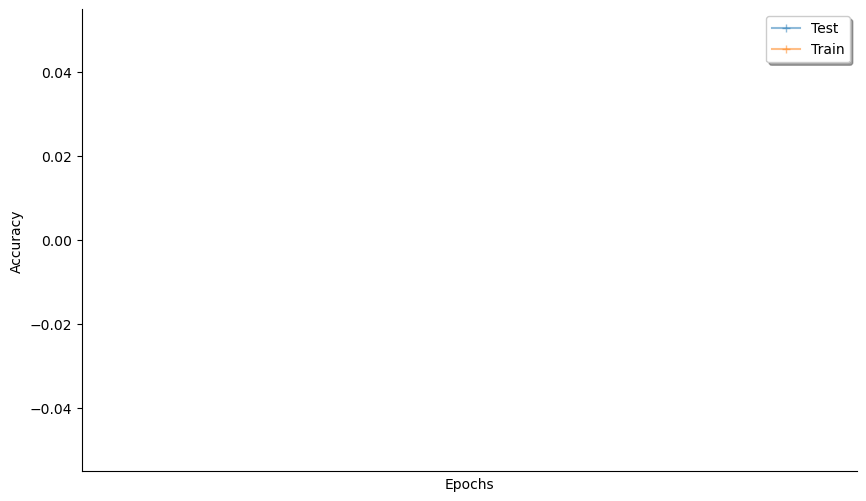

In [33]:
# plot train and validation (prediction) accuracies against each other to examine whether model overfits the training data
visualization.plot_single_performance(
                                        plots_dir=plots_dir,
                                        val_accs=val_accs,
                                        train_accs=train_accs,
                                        steps=steps,
                                        show_plot=True
)

C:\Projects\VICE\visualization.py:103: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([0, len(losses[i])])


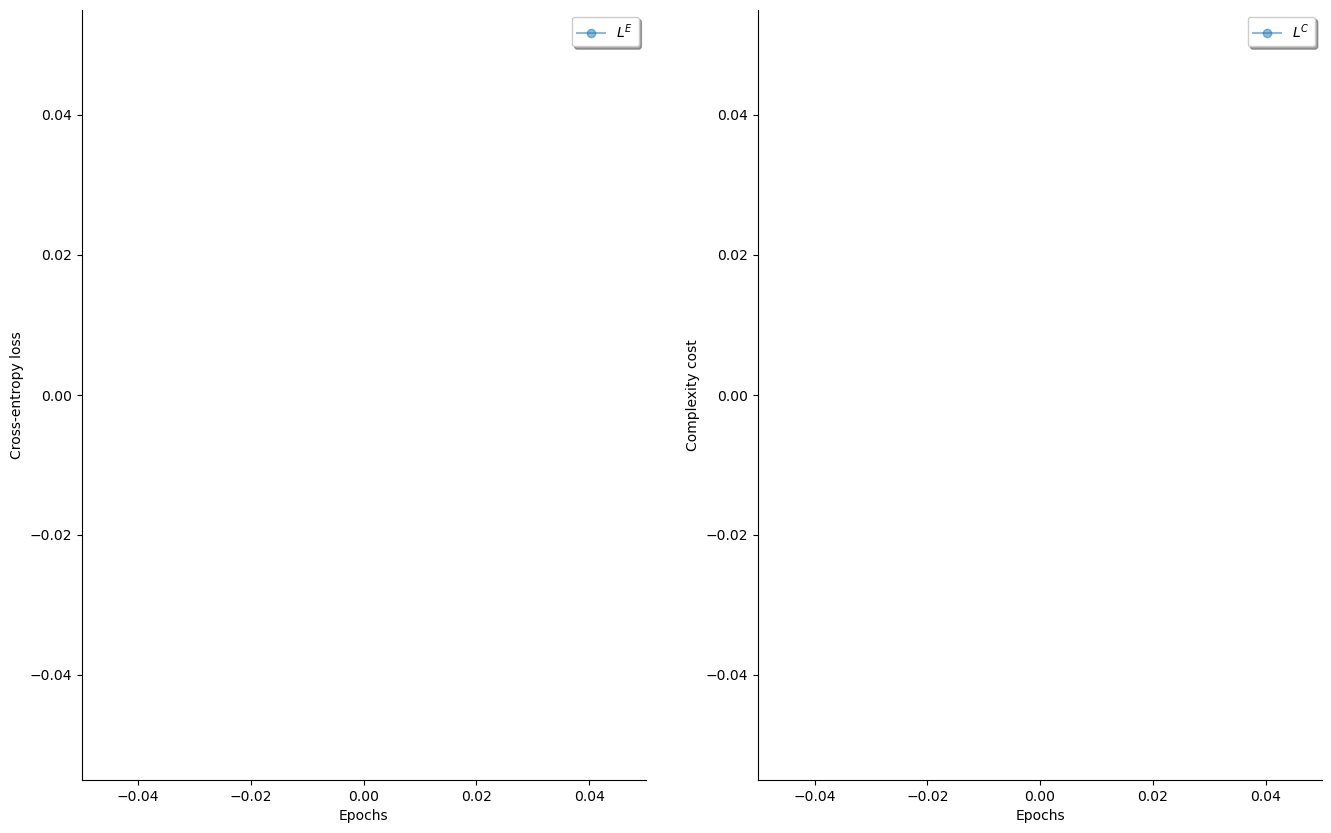

In [34]:
# plot complexity losses (KLDs) and log-likelihoods over time
visualization.plot_complexities_and_loglikelihoods(
                                                    plots_dir=plots_dir,
                                                    loglikelihoods=loglikelihoods,
                                                    complexity_losses=complexity_losses,
                                                    show_plot=True
)

In [ ]:
# plot number of latent dimensions (identified dimensions after pruning) over time
visualization.plot_latent_dimensions(
                                plots_dir=plots_dir,
                                latent_dimensions=latent_dimensions,
                                show_plot=True
)

### Save unpruned locations and scales after convergence

In [ ]:
# get means and standard deviations
params = vice.detached_params
loc=params['loc']
scale=params['scale']

In [ ]:
# compress model params and store as binary files
with open(os.path.join(results_dir, 'parameters.npz'), 'wb') as f:
    np.savez_compressed(f, loc=loc, scale=scale)

### Load pruned locations and scales of converged VICE model for downstream applications

In [ ]:
# load pruned VICE params
pruned_params = vice.pruned_params
pruned_loc = pruned_params['pruned_loc']
pruned_scale = pruned_params['pruned_scale']